# Case Study: Palladium Catalyzed AAA reactions 
#### Goal: Test effect of random seed on model outputs

In [17]:
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from prepare_dataset import prepare_dataset
plt.rcParams.update(plt.rcParamsDefault)

sys.path.append('../src')
import rccr


### Dataset preparation

read in data

In [3]:
df = prepare_dataset('../data/Palladium_Database.xlsx')

split data, transform to high variance principal components

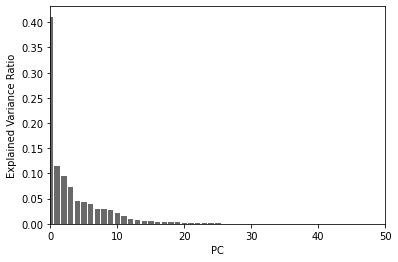

In [4]:
df_train, df_test = train_test_split(df,test_size=0.1, random_state=25)

X_train = df_train.iloc[:,6:]
X_test = df_test.iloc[:,6:]
y_train = df_train['DDG']
y_test = df_test['DDG']

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA().fit(X_train_scaled)
pcs = pca.transform(X_train_scaled)[:,:20]
pcs_test = pca.transform(X_test_scaled)[:,:20]

plt.bar(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, color='dimgrey')
plt.xlabel('PC')
plt.ylabel('Explained Variance Ratio')
plt.xlim(0,50)
plt.show()

### Apply RCCR with no ensemble

In [31]:
from joblib import Parallel, delayed

def repeat_func(x,y, seed):
    new_labels = rccr.rc_fit(x,y, n_clusters=6, random_seed=seed)
    cr_meas, cr_pred, clusters = rccr.cr_fit(x,y,labels=new_labels)
    r2 = r2_score(cr_meas,cr_pred)
    mae = mean_absolute_error(cr_meas,cr_pred)
    print("Seed " + str(seed) + " DONE!")
    return(r2,mae)


output = Parallel(n_jobs=4)(delayed(repeat_func)(pcs,y_train.values,i) for i in range(0,100))  
r2_list = []
mae_list = []
for item in output:
    r2_list.append(item[0])
    mae_list.append(item[1])

Initial r2 0.35198922900505397
Initial r2 0.35198922900505397
Initial r2 0.35198922900505397
Initial r2 0.35198922900505397
Iteration 0 0.8046208795086823
Iteration 0 0.8071453152628142
Iteration 0 0.8267154301424887
Iteration 0 0.8034601576975113
Iteration 1 0.8630393136339262
Iteration 1 0.8738874836600452
Iteration 1 0.8725994907548733
Iteration 1 0.8858342834699319
Final r2 0.8726831821732661
Cluster 0 R2 0.8048690552261156 coeff [0.6281382368205851][10] int 1.1156718794595337
Cluster 1 R2 0.8732775787300463 coeff [0.8494823308138166][13] int 1.504434277203513
Cluster 2 R2 0.8509951356137624 coeff [0.5393023119671201][2] int 3.021947963320561
Cluster 3 R2 0.8407045670150153 coeff [0.41347712281751453][4] int 1.671051093947789
Cluster 4 R2 0.871810516081524 coeff [0.32255563851285024][9] int 1.692457206643076
Cluster 5 R2 0.9944422403731331 coeff [0.4623863989544675][11] int 1.8974097459918602
Seed 2 DONE!
Final r2 0.884016701602539
Cluster 0 R2 0.790976760125226 coeff [0.6508096524

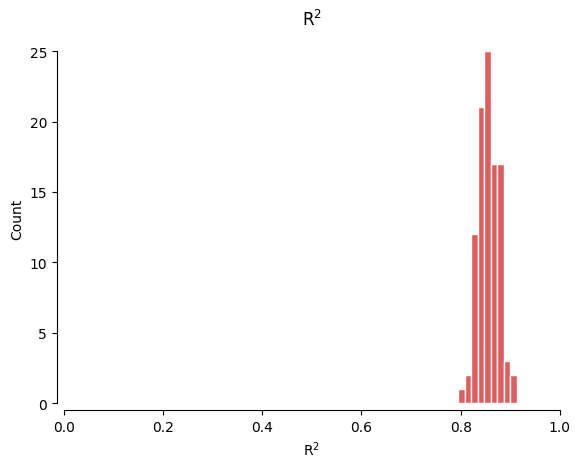

In [34]:
sns.histplot(x=r2_list, edgecolor='white', color='tab:red', multiple='stack')
plt.xlim(0,1)
sns.despine(offset=5, trim=True)
plt.xlabel('R$^2$')
plt.legend('', frameon=False)
plt.title('R$^2$')
plt.show()

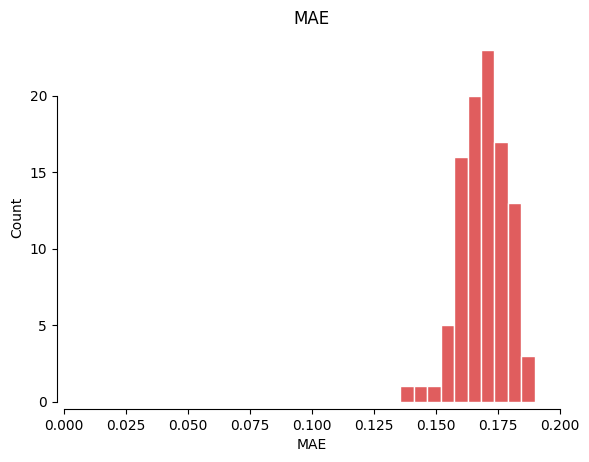

In [37]:
sns.histplot(x=mae_list, edgecolor='white', color='tab:red', multiple='stack')
plt.xlim(0,.2)
sns.despine(offset=5, trim=True)
plt.xlabel('MAE')
plt.legend('', frameon=False)
plt.title('MAE')
plt.show()

## Apply RCCR with ensemble

In [45]:
ensemble_r2_list = []
ensemble_mae_list = []

for i in range(0,100):
    new_labels = rccr.get_average_clusters(pcs, y_train.values,n_clusters=6, iterations=5, max_iteration_cluster=3, plot=False, random_seed = i)
    cr_meas, cr_pred, clusters = rccr.cr_fit(pcs,y_train.values,labels=new_labels)
    ensemble_r2_list.append(r2_score(cr_meas,cr_pred))
    ensemble_mae_list.append(mean_absolute_error(cr_meas,cr_pred))
    print("RUN " + str(i) + " COMPLETE!")



Initial r2 0.35198922900505397
Initial r2 0.35198922900505397
Initial r2 0.35198922900505397
Initial r2 0.35198922900505397
Iteration 0 0.8046208795086823
Iteration 0 0.8071453152628142
Iteration 0 0.8267154301424887
Iteration 0 0.8034601576975113
Iteration 1 0.8630393136339262
Iteration 1 0.8738874836600452
Iteration 1 0.8725994907548733
Iteration 1 0.8858342834699319
Final r2 0.8726831821732661
Final r2 0.884016701602539
Initial r2 0.35198922900505397
Final r2 0.8776592256733428
Final r2 0.8941589148592367
Iteration 0 0.8213030960676742
Iteration 1 0.8619613894292715
Final r2 0.8633512628436882
Cluster 0 R2 0.9132546335127363 coeff [0.49549070494202685][4] int 1.9427322855367464
Cluster 1 R2 0.7731167678305408 coeff [0.6031819104342403][10] int 1.1335863659655339
Cluster 2 R2 0.8665165278347523 coeff [0.5469195306072466][2] int 3.073361662595635
Cluster 3 R2 0.873385868659961 coeff [0.31688936010069146][9] int 1.6675276326319373
Cluster 4 R2 0.8808604860120705 coeff [0.85753707649656

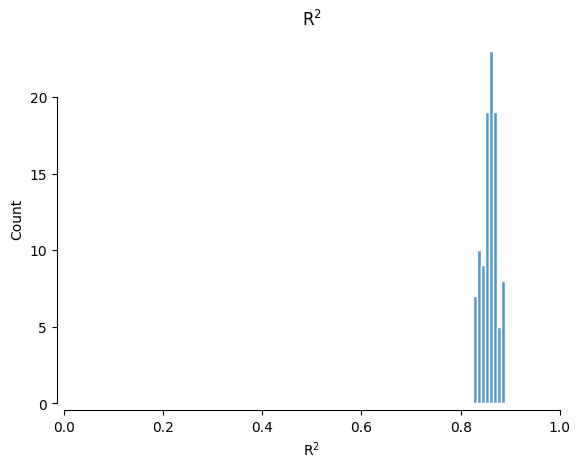

In [46]:
sns.histplot(x=ensemble_r2_list, edgecolor='white', color='tab:blue', multiple='stack')
plt.xlim(0,1)
sns.despine(offset=5, trim=True)
plt.xlabel('R$^2$')
plt.legend('', frameon=False)
plt.title('R$^2$')
plt.show()

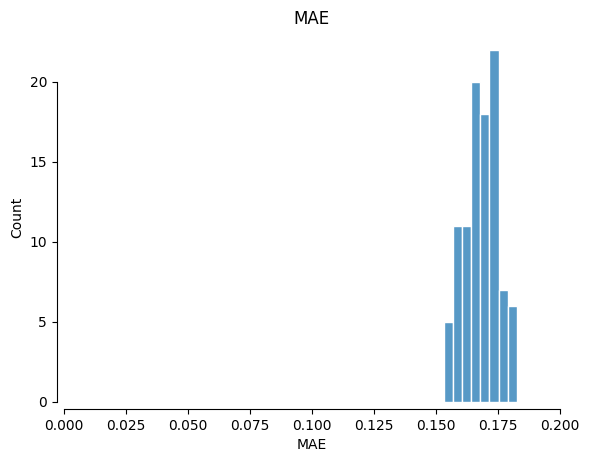

In [62]:
sns.histplot(x=ensemble_mae_list, edgecolor='white', color='tab:blue', multiple='stack')
plt.xlim(0,0.2)
sns.despine(offset=5, trim=True)
plt.xlabel('MAE')
plt.legend('', frameon=False)
plt.title('MAE')
plt.show()

## Apply RCCR with ensemble, repeat 50 times

In [ ]:
ensemble_r2_list = []
ensemble_mae_list = []

for i in range(0,20):
    new_labels = rccr.get_average_clusters(pcs, y_train.values,n_clusters=6, iterations=40, max_iteration_cluster=3, plot=False, random_seed = i, num_jobs=8)
    cr_meas, cr_pred, clusters = rccr.cr_fit(pcs,y_train.values,labels=new_labels)
    ensemble_r2_list.append(r2_score(cr_meas,cr_pred))
    ensemble_mae_list.append(mean_absolute_error(cr_meas,cr_pred))
    print("RUN " + str(i) + " COMPLETE!")


In [24]:
print('Max R2 ' + str(np.max(ensemble_r2_list)))
print('Min R2 ' + str(np.min(ensemble_r2_list)))

print('Std R2 '+ str(np.std(ensemble_r2_list)))

print('Max R2 ' + str(np.max(ensemble_mae_list)))
print('Min R2 ' + str(np.min(ensemble_mae_list)))

print('Std R2 '+ str(np.std(ensemble_mae_list)))


Max R2 0.8807408167753416
Min R2 0.8751943218440457
Std R2 0.0013247695130164951
Max R2 0.15855592931872386
Min R2 0.152681364141713
Std R2 0.0014992120907799569
